In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-



## Simple RNN 2 Features
## Weather dataset 


In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)
EPOCHS = 20 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))
data_df.shape

(96453, 12)

In [8]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Take care of time zones

In [9]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc=True)

In [10]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


Apparent Temp: Feels like temp. Its mixture of temp, humidity and wind. 

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [12]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [13]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

Picking the numerical columns

In [14]:
num_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']

len(num_cols)

8

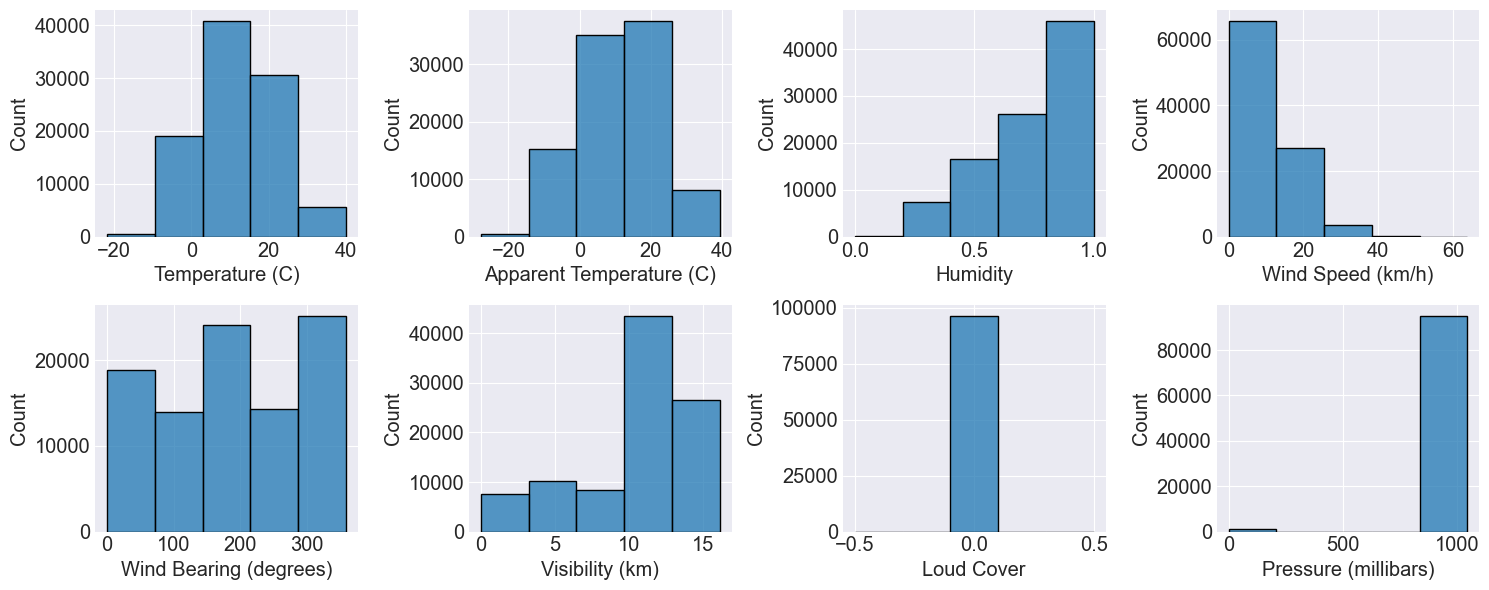

In [15]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=5)

plt.tight_layout()

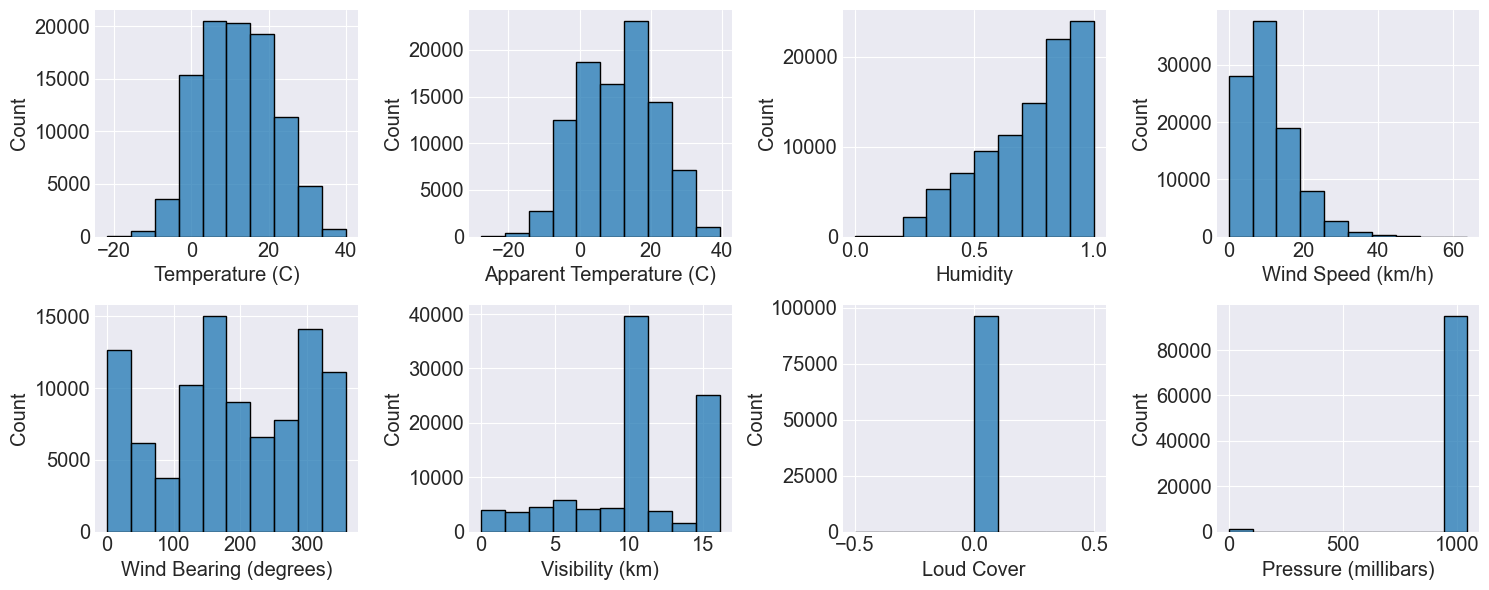

In [16]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=10)

plt.tight_layout()

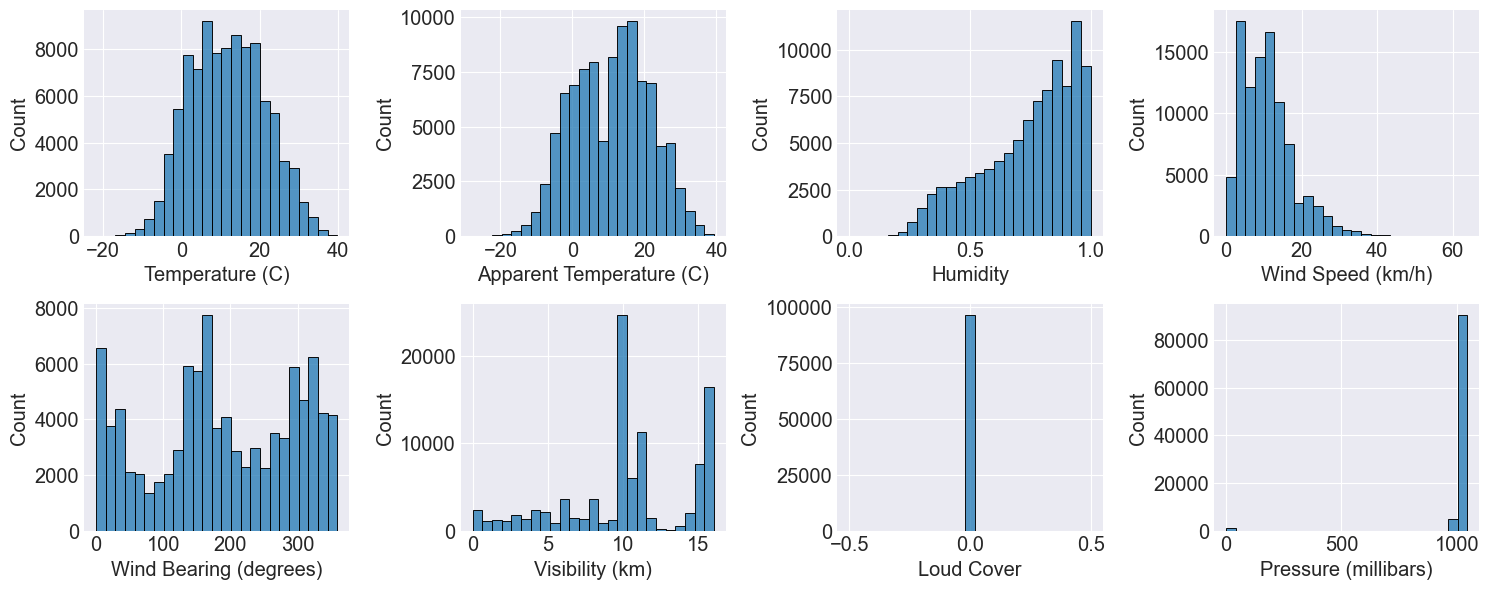

In [17]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=25)

plt.tight_layout()

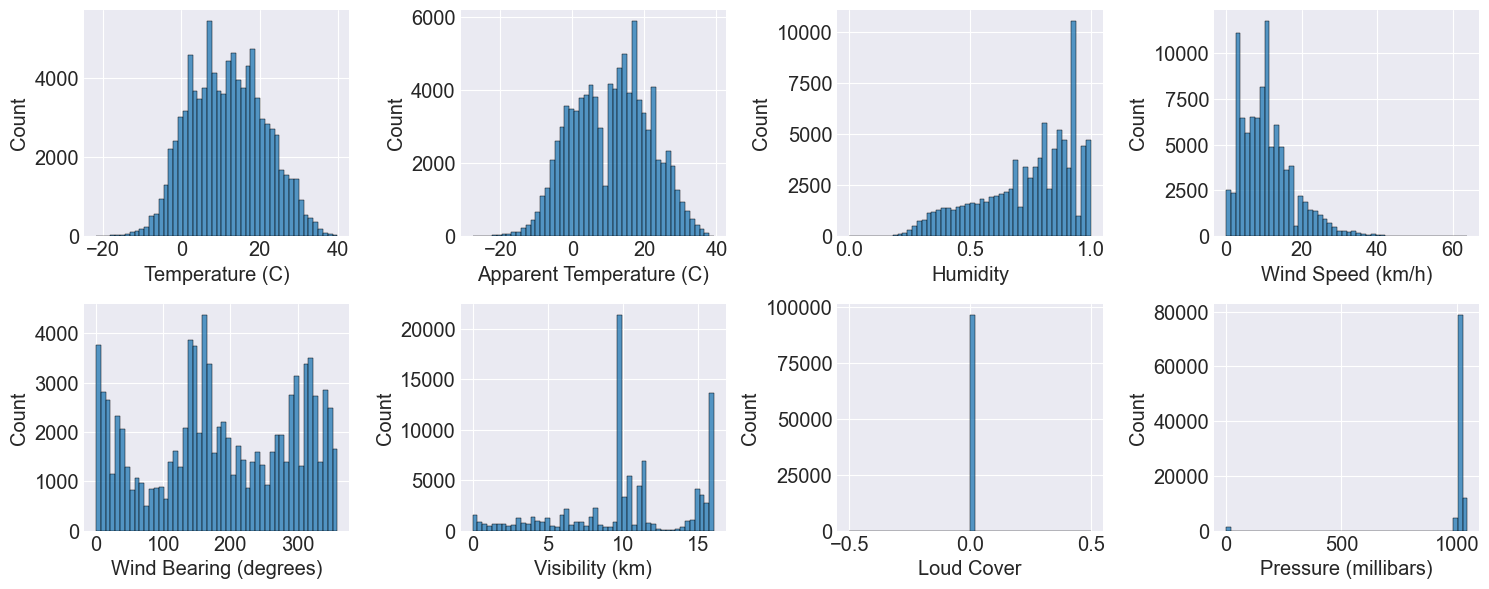

In [18]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.histplot(data_df, x = col, ax = ax, bins=50)

plt.tight_layout()

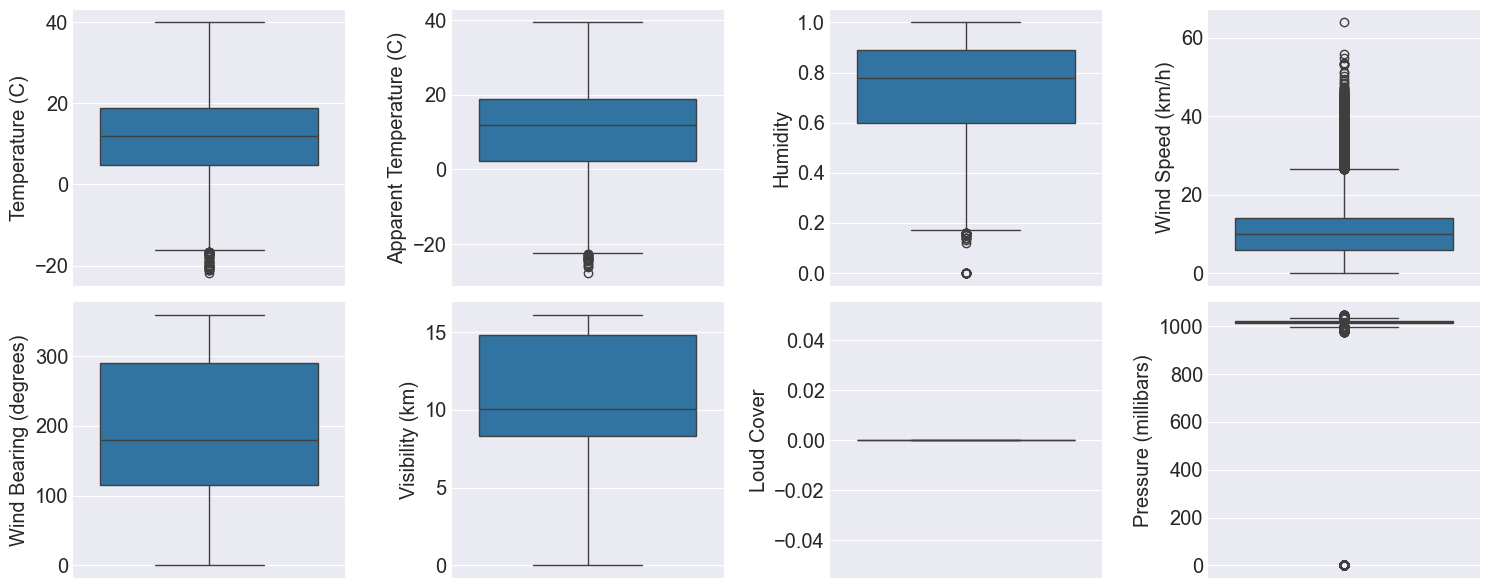

In [19]:
import seaborn as sns

fig,axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate (num_cols):
    ax = axes[count]

    sns.boxplot(data= data_df, y= col, ax = ax)

plt.tight_layout()

In [20]:
data_df[num_cols].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


<Axes: >

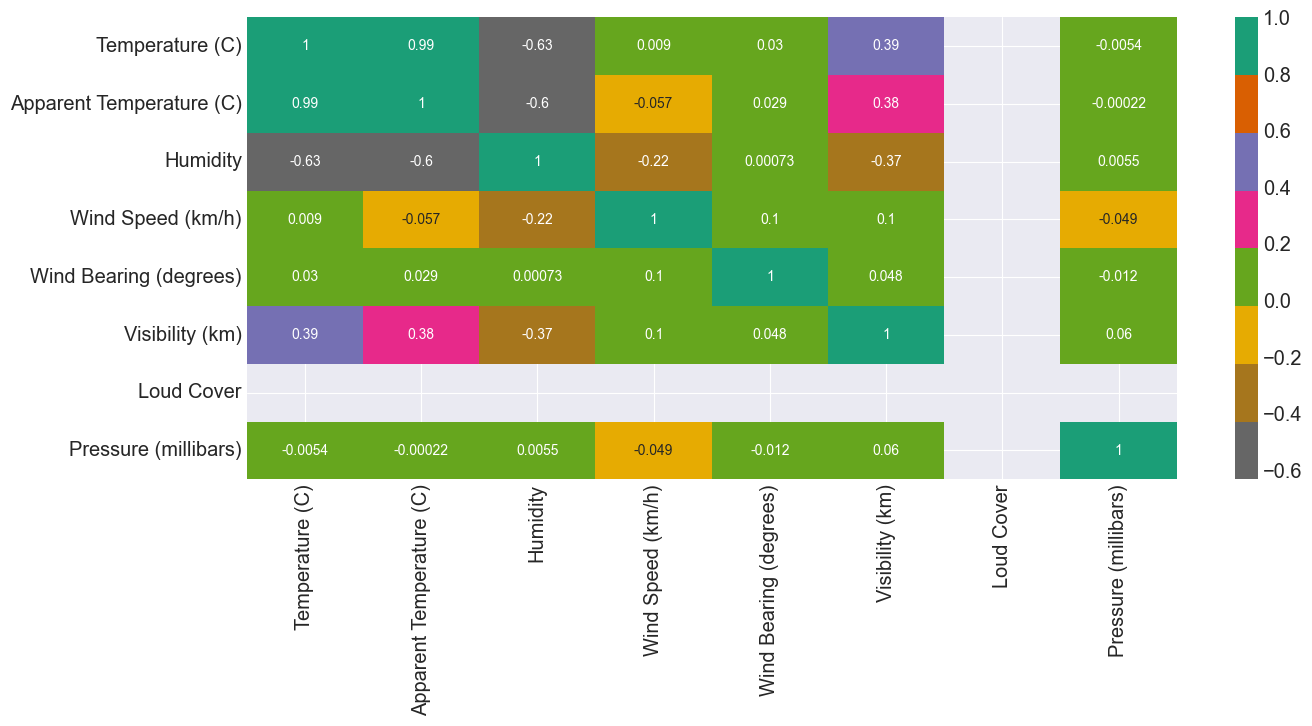

In [21]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap='Dark2_r')

In [22]:
temp_df = data_df[['datetime', 'Temperature (C)', 
                   'Visibility (km)', 'Humidity']]
temp_df = temp_df.sort_values('datetime', ascending= True, axis=0)
temp_df = temp_df.reset_index(drop = True)
temp_df.head()


,datetime,Temperature (C),Visibility (km),Humidity
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


In [23]:
temp_df = temp_df.rename({'Temperature (C)' : 'temp', 'Visibility (km)': 'viz', 'Humidity': 'hum'}, axis= 1)
temp_df.head()

,datetime,temp,viz,hum
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


<Axes: xlabel='datetime'>

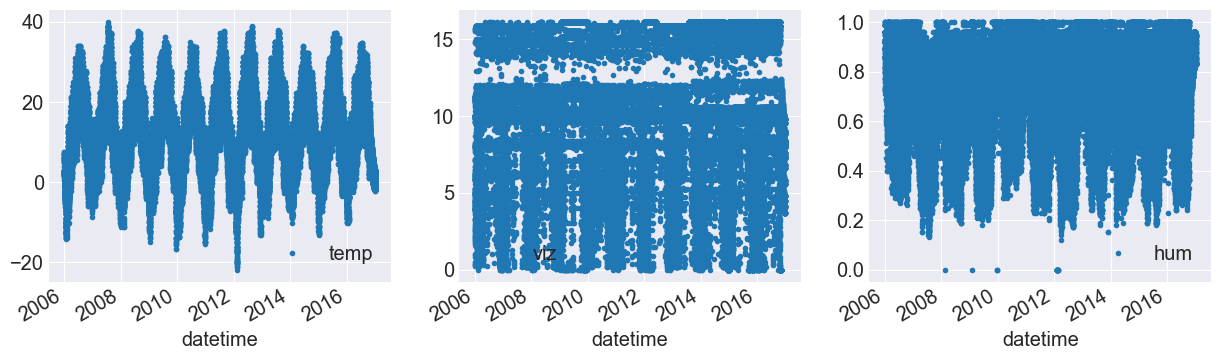

In [24]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(1,3,1)
temp_df.plot(x= 'datetime', y= 'temp', style='.', ax=ax)

ax = fig.add_subplot(1,3,2)
temp_df.plot(x= 'datetime', y= 'viz', style='.', ax=ax)

ax = fig.add_subplot(1,3,3)
temp_df.plot(x= 'datetime', y= 'hum', style='.', ax=ax)


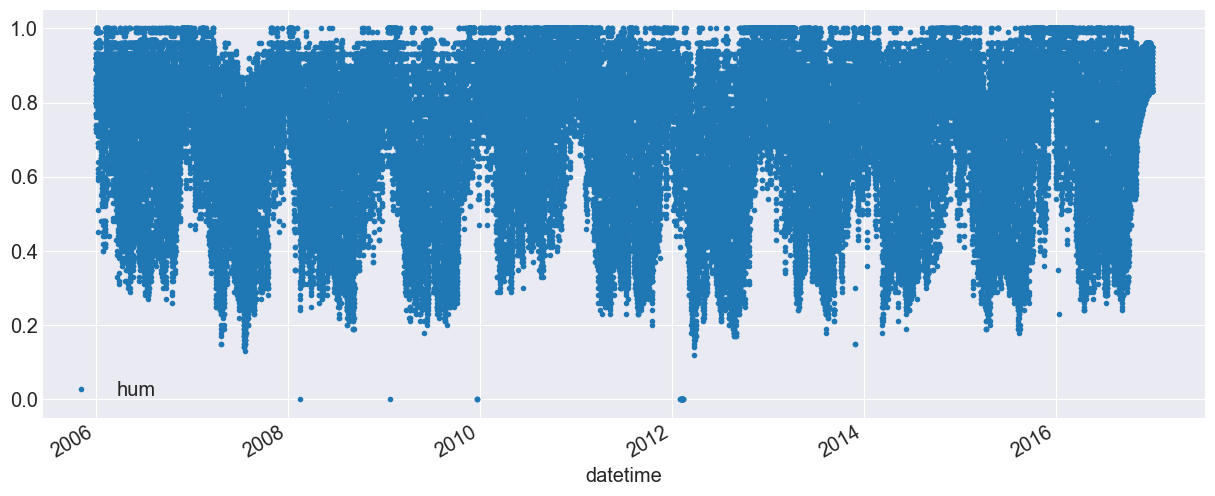

In [25]:
temp_df.plot(x= 'datetime', y= 'hum', style='.');

In [26]:
time_step = 24

y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_idx.shape

y_df = temp_df.iloc[y_idx][['datetime', 'temp']]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [27]:
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp,viz,hum
24,2006-01-01 23:00:00+00:00,5.422222,15.6492,0.86
48,2006-01-02 23:00:00+00:00,1.694444,4.4919,0.92
72,2006-01-03 23:00:00+00:00,2.200000,9.5795,0.89
96,2006-01-04 23:00:00+00:00,1.666667,9.9015,0.92
120,2006-01-05 23:00:00+00:00,1.805556,2.2057,0.99


In [28]:
y_df.shape

(4018, 4)

In [29]:
y_df.shape[0] * time_step

96432

In [30]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]
X_df.shape

(96432, 4)

In [31]:
X_df.head()

,datetime,temp,viz,hum
0,2005-12-31 23:00:00+00:00,0.577778,9.9820,0.89
1,2006-01-01 00:00:00+00:00,1.161111,9.9015,0.85
2,2006-01-01 01:00:00+00:00,1.666667,9.9015,0.82
3,2006-01-01 02:00:00+00:00,1.711111,9.9015,0.82
4,2006-01-01 03:00:00+00:00,1.183333,9.9015,0.86


In [32]:
X_temp = np.reshape(X_df['temp'].to_numpy(), (y_df.shape[0], time_step))

X_hum = np.reshape(X_df['hum'].to_numpy(), (y_df.shape[0], time_step))

X_viz = np.reshape(X_df['viz'].to_numpy(), (y_df.shape[0], time_step))

In [46]:
y_df.shape

(4018, 4)

In [45]:
X_temp.shape

(4018, 23)

In [47]:
X_temp

array([[ 0.57777778,  1.16111111,  1.66666667, ...,  5.97222222,
         4.93333333,  5.47222222],
       [ 5.42222222,  2.35      ,  5.42222222, ...,  2.85555556,
         2.80555556,  2.31111111],
       [ 1.69444444,  1.73333333,  1.66666667, ...,  2.24444444,
         2.24444444,  2.25555556],
       ...,
       [-1.67777778, -1.93333333, -2.03333333, ..., -0.54444444,
        -0.78333333, -1.06666667],
       [-1.72777778, -1.98888889, -2.08333333, ..., -0.59444444,
        -0.82777778, -1.11666667],
       [-1.77777778, -2.03333333, -2.13333333, ..., -0.63888889,
        -0.87222222, -1.16111111]])

In [33]:
X_temp = X_temp[:, :23]
X_hum = X_hum[:, :23]
X_viz = X_viz[:, :23]

X_temp.shape, X_hum.shape, X_viz.shape

((4018, 23), (4018, 23), (4018, 23))

In [48]:
X_temp.shape

(4018, 23)

Input shape expectations = `[batch, timestep, feature]`

In [34]:
X_data = np.stack((X_temp, X_hum), axis=2)
X_data.shape

(4018, 23, 2)

In [35]:
split = int(y_df.shape[0] * (1 - TEST_SIZE))
X_train = X_data[:split]
X_test = X_data[split:]

y_train = y_df['temp'].to_numpy()[:split]
y_test = y_df['temp'].to_numpy()[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3214, 23, 2), (804, 23, 2), (3214,), (804,))

In [36]:
h_units = 256
input_shape = (time_step-1, X_train.shape[2])

model = tf.keras.Sequential()

model.add(tf.keras.layers.SimpleRNN(units= h_units,
                                    input_shape=input_shape,
                                    activation='tanh'))

model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', 
              metrics = [tf.keras.metrics.RootMeanSquaredError()],
              loss='mean_squared_error')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66304     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 66561 (260.00 KB)
Trainable params: 66561 (260.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
history = model.fit(X_train, y_train, 
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    verbose = 2)

Epoch 1/20

101/101 - 3s - loss: 12.0204 - root_mean_squared_error: 3.4670 - val_loss: 1.0509 - val_root_mean_squared_error: 1.0251 - 3s/epoch - 31ms/step
Epoch 2/20
101/101 - 2s - loss: 1.8241 - root_mean_squared_error: 1.3506 - val_loss: 0.8949 - val_root_mean_squared_error: 0.9460 - 2s/epoch - 16ms/step
Epoch 3/20
101/101 - 2s - loss: 1.3613 - root_mean_squared_error: 1.1667 - val_loss: 0.8108 - val_root_mean_squared_error: 0.9004 - 2s/epoch - 16ms/step
Epoch 4/20
101/101 - 2s - loss: 1.2631 - root_mean_squared_error: 1.1239 - val_loss: 0.8670 - val_root_mean_squared_error: 0.9311 - 2s/epoch - 16ms/step
Epoch 5/20
101/101 - 2s - loss: 1.2038 - root_mean_squared_error: 1.0972 - val_loss: 0.7441 - val_root_mean_squared_error: 0.8626 - 2s/epoch - 15ms/step
Epoch 6/20
101/101 - 2s - loss: 1.1563 - root_mean_squared_error: 1.0753 - val_loss: 0.9154 - val_root_mean_squared_error: 0.9568 - 2s/epoch - 16ms/step
Epoch 7/20
101/101 - 2s - loss: 1.0868 - root_mean_squared_error: 1.0425 - val_l

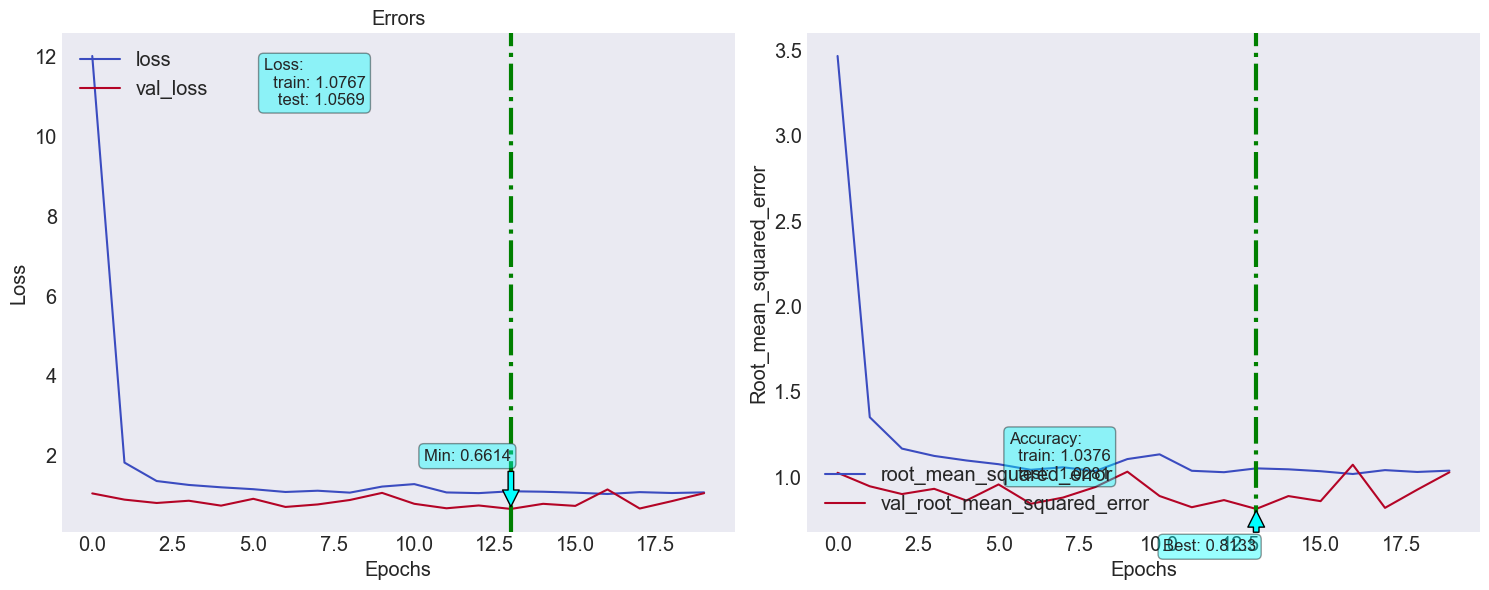

In [39]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [40]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
13,1.104534,1.050968,0.661426,0.813281


In [41]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_pred = np.append(y_train_pred, y_test_pred)

y_pred.shape

26/26 [==============================] - 0s 8ms/step


(4018,)

In [42]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,viz,hum,pred
24,2006-01-01,5.422222,15.6492,0.86,4.386669
48,2006-01-02,1.694444,4.4919,0.92,1.113153
72,2006-01-03,2.200000,9.5795,0.89,1.414916
96,2006-01-04,1.666667,9.9015,0.92,1.302369
120,2006-01-05,1.805556,2.2057,0.99,1.827857


#### How we can make it more Accurate ?

- Add more Fatures
- Add more Data (Interpret it Hourly basis or subgroups as Hourly)

<Axes: xlabel='datetime'>

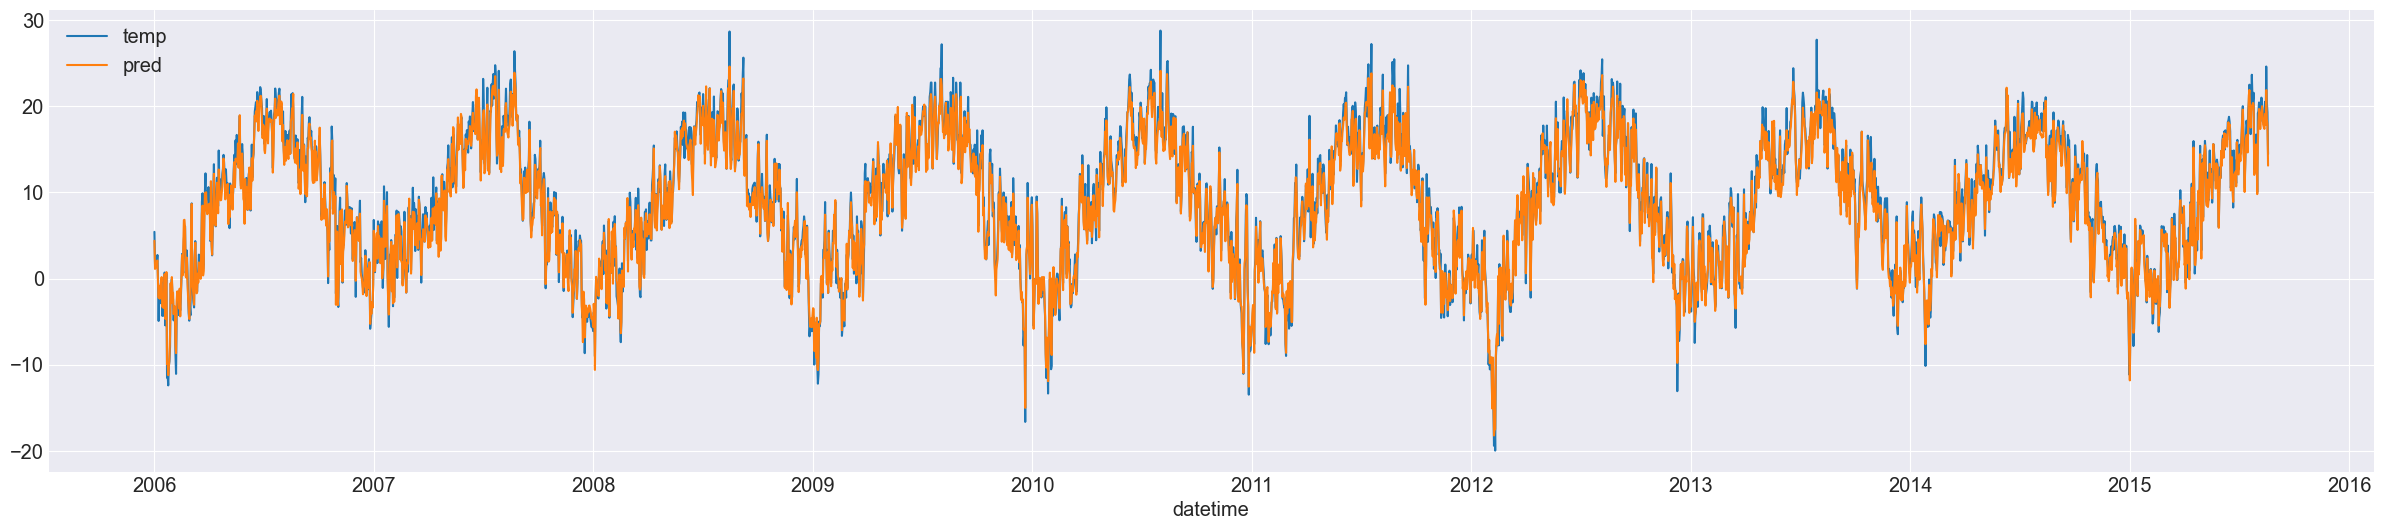

In [43]:
fig, ax = plt.subplots(figsize = (30,6))

res_df[:-500].plot(x = 'datetime', y = ['temp', 'pred'], ax = ax)